# Convolutional Neural Network for Shape Classification

In [1]:
import torch 
import torch.nn as nn
import matplotlib.pylab as plt
from torch.utils.data import Dataset, DataLoader

<font size="4">Import necessary libraries for tensor manipulation, neural network construction, and plotting. </font>

In [2]:
train_img_list = torch.load('train_img__list.pt')
train_label_list = torch.load('train_label_list.pt')
test_img_list = torch.load('test_img_list.pt')
test_label_list = torch.load('test_label_list.pt')

<font size="4">Import torch tensors corresponding to the images and labels in both test and training sets.</font>

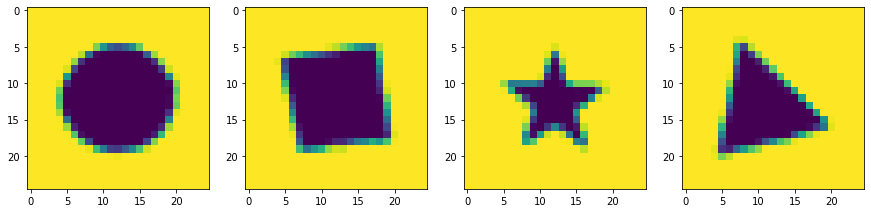

In [3]:
fig, axs = plt.subplots(1, 4, figsize=(15,15))
axs[0].imshow(train_img_list[0].permute(1, 2, 0) )
axs[1].imshow(train_img_list[3000].permute(1, 2, 0) )
axs[2].imshow(train_img_list[6000].permute(1, 2, 0) )
axs[3].imshow(train_img_list[9000].permute(1, 2, 0) )
plt.show()


<font size="4">Above I have plotted examples of the four shapes to classify in this code. (circle, square, star, triangle)
Images are formed by a grid of 25 by 25 grayscale pixels.</font>

In [4]:
class Dataset(Dataset):

    # Constructor
    def __init__(self, passed_labels, passed_img_list,  transform=None):  
        self.labels = passed_labels
        self.img_data = passed_img_list
        self.len = len(self.labels)
    
    #get method returning sample    
    def __getitem__(self, idx):
        call_image = self.img_data[idx]
        call_label = self.labels[idx]
        return call_image, call_label
   
    def __len__(self):
        return self.len

<font size="4">The dataset class is introduced above; this class will take in images and labels as inputs for the dataset.
The class is modified to return a sample image tensor and sample label when an index is called.
In addition, this returns the length of the dataset (the number of samples in the dataset).</font>

In [5]:
training_dataset = Dataset( train_label_list, train_img_list)
test_dataset = Dataset( test_label_list, test_img_list)

<font size="4">Create datasets for training and testing(validation).</font>

In [6]:
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

<font size="4">The method above will compute the output of a convolution. This will be used to compute the output of the CNN. </font>

In [7]:
#the first line below computes the output of a convolution with a 5 by 5 kernel, with one zero edge padding and stride of 1.
#the second line below computes the output of a maxpooling operation with a kernel size of 2, and stride of 1.
h1,w1 = conv_output_shape([25,25],5,1,1)
h1_final, w1_final = conv_output_shape([h1,w1],2,1,0)

#Given the output of the convolution above we repeat this is a second layer.
h2,w2 = conv_output_shape([h1_final, w1_final],5,1,1)
h2_final, w2_final = conv_output_shape([h2,w2],2,1,0)

print(h2_final, w2_final)

19 19


<font size="4">The lines above compute the output of a proposed network with two convolutions. This helps determine the input size fed into a fully connected layer that computes the output.</font>

In [8]:
class CNN(nn.Module):
    def __init__(self,out_1=2,out_2=1, batch_norm=False, kern_size=5, out_size=19, init_weight=False):
        #inherit from nn.Module
        super(CNN,self).__init__()
        
        self.batch_n = batch_norm
        self.weight_init = init_weight
        self.kernal_dim = kern_size
        self.output_dim = out_size
        
        #first Convolutional layers 
        self.cnn1 = nn.Conv2d(in_channels=1,out_channels=out_1,kernel_size=self.kernal_dim,stride=1,padding=1)
        if  self.weight_init == True:  
            torch.nn.init.kaiming_uniform_(self.cnn1.weight, nonlinearity='relu')
        if self.batch_n == True:
            self.conv1_bn = nn.BatchNorm2d(out_1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2 ,stride=1)
        
        #second Convolutional layers
        self.cnn2 = nn.Conv2d(in_channels=16,out_channels=out_2,kernel_size=self.kernal_dim,stride=1,padding=1)
        if  self.weight_init == True:   
            torch.nn.init.kaiming_uniform_(self.cnn2.weight, nonlinearity='relu')
        if self.batch_n == True:
            self.conv2_bn = nn.BatchNorm2d(out_2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2 ,stride=1)
        
        ##should be 19 by 19
        #fully connected layer 
        self.fc1 = nn.Linear(out_2*self.output_dim*self.output_dim ,4)
        if  self.weight_init == True:  
            torch.nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        if self.batch_n == True:
            self.bn_fc1 = nn.BatchNorm1d(4)
        
    def forward(self,x):       
        #first Convolutional layers
        x = self.cnn1(x)
        #apply corresponding batch normalization 
        if self.batch_n == True:
            x = self.conv1_bn(x)
        #activation function 
        x = torch.relu(x)
        #max pooling 
        x = self.maxpool1(x)
        
        #second Convolutional layers
        x = self.cnn2(x)
        if self.batch_n == True:
            x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x) 
        
        #flatten output 
        x = x.view(x.size(0),-1)
        #fully connected layer
        x = self.fc1(x)
        if self.batch_n == True:    
            x = self.bn_fc1(x)
        
        return x
    

<font size="4"> Above I created a class for a particular neural network structure. The class takes an image tensor as input which is manipulated by two hidden convolutional layers and a fully connected layer to output a value for each of our four shape classes. 

The input is manipulated by a kernel convolution, followed by batch normalization (if the user desires), application of a ReLu activation function and max pooling. This is repeated for a second layer. The output is flatten and transformed by a fully connected layer and another batch normalization to obtain the final output.  </font>

In [9]:

model = CNN(16,32, True, 5, 19, False)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

<font size="4">The CNN model is initialized with the selected number of output channels after each layer. Cross entropy is selected as the loss function used for training. I selected to use stochastic gradient descent and the corresponding learning rate for training/minimization. </font>

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=training_dataset,batch_size=1500)
validation_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=1000)

<font size="4">Dataloader objects are formed to create iterable batches from the datasets formed.</font>

In [11]:
def train_model(train_dataloader, validation_dataloader, CNN_model, optim_method):
    n_epochs = 10
    cost_list = []
    accuracy_list = []
    N_test = len(test_dataset)

    for epoch in range(n_epochs):
        cost = 0  
        counter = 0
        correct = 0

        #compute test data loss and validation accuracy for initialized model without training
        if epoch==0:
            for x, y in train_dataloader:
                #eval mode is activated to use averaged batch normalization values for final evalution (not training)
                CNN_model.eval()
                #make a prediction 
                z = CNN_model(x)
                # calculate loss 
                loss = criterion(z,y)
                cost+=loss.item()
            cost_list.append(cost)
            for x_test, y_test in validation_dataloader:
                z = CNN_model(x_test)
                _,yhat = torch.max(z.data,1)
                correct+=(yhat==y_test).sum().item()
            accuracy = correct/N_test
            accuracy_list.append(accuracy)
            cost=0
            correct=0

        for x, y in train_dataloader:
            #train mode activated to compute batch normalization for the particular batch
            CNN_model.train()
            counter = counter+1
            if counter%2 == 0:
                print('On epoch: ',epoch,' having trained: ',counter,' number of batches.')
            #clear gradient 
            optim_method.zero_grad()
            #make a prediction 
            z = CNN_model(x)
            # calculate loss 
            loss = criterion(z,y)
            # calculate gradients of parameters 
            loss.backward()
            # update parameters 
            optim_method.step()
            cost+=loss.item()
        cost_list.append(cost)
        print('Done with epoch: ', epoch, ' current cost:', cost)


        #perform a prediction on the validation  data  
        for x_test, y_test in validation_dataloader:
            CNN_model.eval()
            z = CNN_model(x_test)
            _,yhat = torch.max(z.data,1)
            correct+=(yhat==y_test).sum().item()
        accuracy = correct/N_test
        accuracy_list.append(accuracy)
    return accuracy_list, cost_list

<font size="4">The method above iterates through the training process. The loss is recorded for training data and accuracy is recorded for the validation data as the model is updated.</font>

In [12]:
accuracy_list, cost_list = train_model(train_loader, validation_loader, model, optimizer)

C:\Users\15125\anaconda3\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


On epoch:  0  having trained:  2  number of batches.
On epoch:  0  having trained:  4  number of batches.
On epoch:  0  having trained:  6  number of batches.
Done with epoch:  0  current cost: 10.872405886650085
On epoch:  1  having trained:  2  number of batches.
On epoch:  1  having trained:  4  number of batches.
On epoch:  1  having trained:  6  number of batches.
Done with epoch:  1  current cost: 9.639365673065186
On epoch:  2  having trained:  2  number of batches.
On epoch:  2  having trained:  4  number of batches.
On epoch:  2  having trained:  6  number of batches.
Done with epoch:  2  current cost: 9.27736520767212
On epoch:  3  having trained:  2  number of batches.
On epoch:  3  having trained:  4  number of batches.
On epoch:  3  having trained:  6  number of batches.
Done with epoch:  3  current cost: 9.061880588531494
On epoch:  4  having trained:  2  number of batches.
On epoch:  4  having trained:  4  number of batches.
On epoch:  4  having trained:  6  number of ba

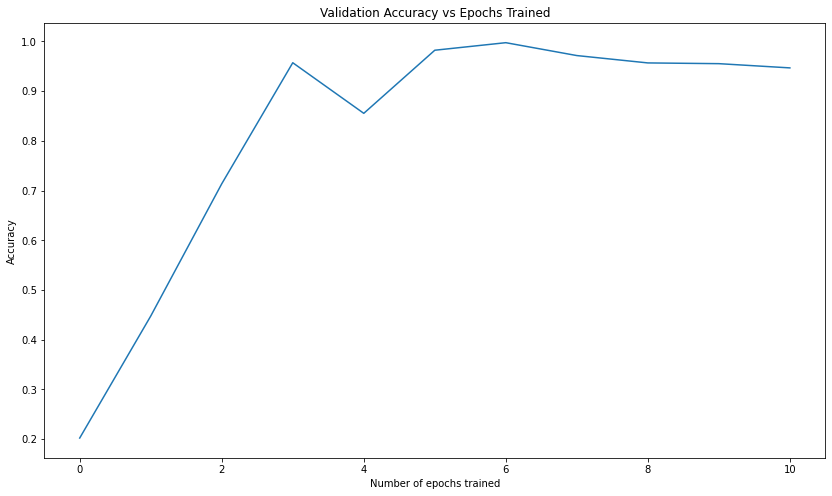

Final validation accuracy of:  0.9467061435973353


In [13]:
plt.figure(figsize=(14, 8))
plt.plot(accuracy_list)
plt.xlabel('Number of epochs trained')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epochs Trained')
plt.show()
print('Final validation accuracy of: ', accuracy_list[-1])

<font size="4">The validation accuracy over the training epochs demonstrates improvement over training. We see an accurate model prediction at least ~85% of samples depending on the particular initialization of the model parameters.</font>

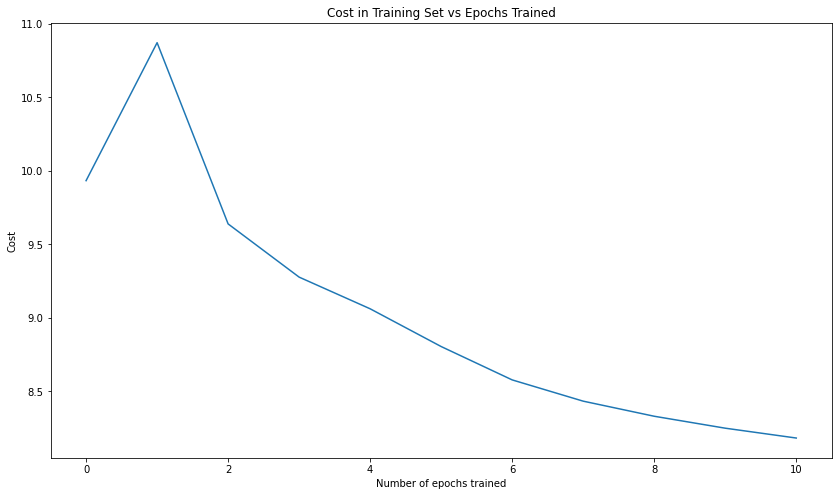

In [14]:
plt.figure(figsize=(14, 8))
plt.plot(cost_list)
plt.xlabel('Number of epochs trained')
plt.ylabel('Cost')
plt.title('Cost in Training Set vs Epochs Trained')
plt.show()

<font size="4">The train set cost is decreasing over training as expected. </font>